Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import cvxpy as cp


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\hando\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\hando\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\hando\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\hando\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\hando\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\hando\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



Neural Network

In [29]:
## Side functions

def trick_matrix(n):                # maybe there's a way to do it without for loops, anyway, it's called only once
    mat_left,mat_right=[[0 for _ in range(32)] for _ in range(n)],[[0 for _ in range(32)] for _ in range(n)]
    for i in range(n):
        for j in range(32):
            mat_left[i][j]=[0 for _ in range(i)]
            mat_right[i][j]=[0 for _ in range(n-1-i)]
    return mat_left,mat_right
def trick_concatenate(x,y,z):
    # x and z will be mat_left and mat_right, and y W1 sized (n,32,3)
    n=np.shape(y)[0]
    w=[]
    for i in range(n):
        row=[]
        for j in range(32):
            row.append(x[i][j]+y[i][j]+z[i][j])
        w.append(row)
    return w


def cost(NN_output,Reality):        # the lists have to be corresponding (ie consistent)
    return np.sum((NN_output - Reality)**2)
def cost_partial_derivative(i,NN_output,Reality):
    return 2*(NN_output[i] - Reality[i])
def cost_partial_derivative_vect(NN_output,Reality):
    return 2*(NN_output - Reality)


def activation(x):
    return np.log(1 + np.exp(x))
def activation_derivative(x):
    return 1/(1 + np.exp(-x))



## Neural network

def initialization(n):
    W1_init=np.random.rand(n, 32, 3)*0.00001
    B1_init=np.random.rand(n, 32)*0.000001
    W2_init=np.random.rand(n, 32)*0.00001
    B2_init=np.random.rand(n)*0.000001
    return W1_init,W2_init,B1_init,B2_init

def forward_propagation(input,W1,W2,B1,B2):    # the inputs (eigenvalues) have to be sorted and W1 has to already have been sumed with the trick matrix...
    # expected sizes : input (n,), W1 (n, 32, n+2), W2 (n, 32), B1 (n, 32), B2 (n,)
    # Input layer
    input_layer=np.pad(input, (1, 1), mode='constant', constant_values=0)
    # Intermediate layer
    Z1=np.tensordot(W1, input_layer, axes=([2], [0]))+B1        # size should be n x 32, what it should do : Z[i,j] = Wij @ input_layer + B[i,j]
    inter_layer=np.vectorize(activation)(Z1)     # applies the activation function to each term of Z
    # Output layer
    Z2 = np.diag(W2 @ inter_layer.T) + B2           # size should be n
    output_layer=np.vectorize(activation)(Z2)
    return output_layer, Z1, Z2

def gradient_calculation(training_cluster,reality_cluster,W1,W2,B1,B2):         # both first lists have to be sorted consistently and W1 has to already have been sumed with the trick matrix...
    # Setting
    def fp_given_inputs_0(i):
        return forward_propagation(training_cluster[i],W1,W2,B1,B2)[0]
    def fp_given_inputs_1(i):
        return forward_propagation(training_cluster[i],W1,W2,B1,B2)[1]
    def fp_given_inputs_2(i):
        return forward_propagation(training_cluster[i],W1,W2,B1,B2)[2]
    outputs=np.array([*map(fp_given_inputs_0,np.arange(len(training_cluster)))])
    Z1=np.array([*map(fp_given_inputs_1,np.arange(len(training_cluster)))])
    Z2=np.array([*map(fp_given_inputs_2,np.arange(len(training_cluster)))])
    n=len(reality_cluster[0])
    N=len(reality_cluster)
    # Calculation : dC/d'inter_layer_neurons' (dC_d1) and dC/d'output_layer' (dC_d2)
    dC_d1 = W2 * np.mean(activation_derivative(Z2) * cost_partial_derivative_vect(outputs, reality_cluster), axis=0)[:, np.newaxis]
    dC_d2 = np.mean(cost_partial_derivative_vect(outputs,reality_cluster), axis=0)
    # Calculation : dC/dw -- layer 1 -> layer 2 and layer 0 -> layer 1
    dC_dW2 = np.sum(activation(Z1) * activation_derivative(Z2)[:, :, None] * dC_d2[:][None, :, None], axis=0) / N
    dC_dW1=np.zeros((n,32,n+2))
    for i in range(n):
        for j in range(32):
            dC_dW1[i,j] = dC_d1[i,j] * np.sign(W1[i,j]) * np.mean(activation_derivative(Z1[:,i,j])[:, np.newaxis] * np.pad(np.array(training_cluster), ((0, 0), (1, 1)), 'constant', constant_values=0), axis=0)
    # Calculation : dC/db -- layer 1 -> layer 2 and layer 0 -> layer 1
    dC_dB2 = (activation_derivative(Z2) * dC_d2).mean(axis=0)
    dC_dB1 = (activation_derivative(Z1) * dC_d1[None, :, :]).mean(axis=0)
    return dC_dW1,dC_dW2,dC_dB1,dC_dB2

def change_parameters(gradient,x,W1,W2,B1,B2):
    # expected sizes : gradient (n,32,n)-(n,32)-(n,)-(n,)-4uplet, a,b > 0, W1 (n, 32, n+2), W2 (n, 32), B1 (n, 32), B2 (n,)
    dC_dW1,dC_dW2,dC_dB1,dC_dB2=gradient
    W1 = W1 - x*dC_dW1
    W2 = W2 - x*dC_dW2
    B1 = B1 - x*dC_dB1
    B2 = B2 - x*dC_dB2
    return W1,W2,B1,B2



## Functions running the network

def training0(training_clusters,reality_clusters,x,repeats):
    #print('Training start')
    N=len(training_clusters)    # number of clusters
    n=len(training_clusters[0][0])  # number of eigenvalues
    W1,W2,B1,B2=initialization(n)
    w1=[[[W1[i,j,k] for k in range(3)] for j in range(32)] for i in range(n)]
    TMl,TMr=trick_matrix(n)
    W1 = np.array(trick_concatenate(TMl,w1,TMr))
    avg_costs=[]
    in_data,oracle_data=np.concatenate(training_clusters),np.concatenate(reality_clusters)
    for _ in range(repeats):
        for k in range(N):
            W1,W2,B1,B2 = change_parameters(gradient_calculation(training_clusters[k],reality_clusters[k],W1,W2,B1,B2),x,W1,W2,B1,B2)
        avg_costs.append(testing(in_data,oracle_data,W1,W2,B1,B2)[0])           # average cost over training data for this repetition
    #print('Training done')
    return W1,W2,B1,B2,avg_costs
def training_program(rep1,x1,rep2,x2,training_clusters,reality_clusters):
    def training(W1,W2,B1,B2,training_clusters,reality_clusters,x,repeats):
        N=len(training_clusters)    # number of clusters
        avg_costs=[]
        in_data,oracle_data=np.concatenate(training_clusters),np.concatenate(reality_clusters)
        for _ in range(repeats):
            for k in range(N):
                W1,W2,B1,B2 = change_parameters(gradient_calculation(training_clusters[k],reality_clusters[k],W1,W2,B1,B2),x,W1,W2,B1,B2)
            avg_costs.append(testing(in_data,oracle_data,W1,W2,B1,B2)[0])           # average cost over training data for this repetition
        return W1,W2,B1,B2,avg_costs
    W1,W2,B1,B2,avg_costs1=training0(training_clusters,reality_clusters,x1,rep1)
    W1,W2,B1,B2,avg_costs2=training(W1,W2,B1,B2,training_clusters,reality_clusters,x2,rep2)
    return W1,W2,B1,B2,np.concatenate([avg_costs1,avg_costs2])

def testing(test_samples,reality_samples,W1,W2,B1,B2):        # W1 has to already have been sumed with the trick matrix...
    #print('Testing start')
    N=len(test_samples)
    all_costs=np.zeros(N)
    def cost_given_inpunts(i):
        return cost(forward_propagation(test_samples[i],W1,W2,B1,B2)[0],reality_samples[i])
    all_costs=np.vectorize(cost_given_inpunts)(np.arange(N))
    mean=np.mean(all_costs)
    max=np.max(all_costs)
    #print('Testing done')
    return mean, max, all_costs

def prediction(past_eigenvalues,W1,W2,B1,B2):       # W1 has to already have been sumed with the trick matrix...
    #print('Prediction start')
    future_eigenvalues=forward_propagation(past_eigenvalues,W1,W2,B1,B2)[0]
    #print('Prediction done')
    return future_eigenvalues



## Data

def make_clusters(past_samples,oracle_eig,batch_size):
    K=batch_size
    # K should be the number of samples in each cluster
    training_clusters,oracle_clusters=[],[]
    n=len(past_samples)
    perm=np.random.permutation(n)
    for i in range(n//K):
        training_clusters.append([past_samples[perm[j]] for j in range(i*K,(i+1)*K)])
        oracle_clusters.append([oracle_eig[perm[j]] for j in range(i*K,(i+1)*K)])
    return training_clusters,oracle_clusters
def make_samples(Past,window,step):
    # Past should be the matrix of the daily variations of each asset, window the period of a sample, and step the time between the start of two samples
    n=np.shape(Past)[1]
    past_samples,oracle_eig=[],[]
    for i in range(np.shape(Past)[0]//step - 2*window):
        eig,vect=np.linalg.eig(np.corrcoef(Past[i*step:i*step+window].T))
        sorted_indices=np.argsort(eig)
        past_samples.append(eig[sorted_indices])
        V=vect[sorted_indices]
        oracle_eig.append([V[j].T @ np.corrcoef(Past[i*step+window:i*step+2*window].T) @ V[j] for j in range(n)])
    return past_samples,oracle_eig

def make_data(Past,window,step):
    #print('Training data start')
    training_samples,oracle_eig=make_samples(Past[:8*np.shape(Past)[0]//10],window,step)
    training_clusters,oracle_clusters = make_clusters(training_samples,oracle_eig,step)
    #print('Test data start')
    test_samples,reality_samples=make_samples(Past[8*np.shape(Past)[0]//10:],window,step)
    #print('Data ready')
    return training_clusters, oracle_clusters, test_samples, reality_samples
def make_data_full(Past,window,step):
    training_samples,oracle_eig=make_samples(Past,window,step)
    training_clusters,oracle_clusters = make_clusters(training_samples,oracle_eig,step)
    return training_clusters, oracle_clusters

Usage

In [30]:
n=20
window=20
step=5

In [ ]:
## Usage - Data - Small

df = pd.read_csv("sp500_prices.csv")
df_prices = df.iloc[:, 1:].astype(float)
stock_opens = df_prices.to_numpy()
stock_opens = stock_opens[:, ~np.isnan(stock_opens).any(axis=0)]
stock_variations = stock_opens[1:] / stock_opens[:-1]
# oldest times at the top and most recent ones at the bottom
past=stock_variations[:8*np.shape(stock_variations)[0]//10,:n]

training_clusters, oracle_clusters, test_samples, reality_samples = make_data(past,window,step)

In [42]:
## Usage - Data - Big

corr_Training_Before = np.load("saved_matrices/before_in_sample.npy", allow_pickle=True)
corr_Training_After = np.load("saved_matrices/after_in_sample.npy", allow_pickle=True)
N=np.shape(corr_Training_Before)[0]
n=np.shape(corr_Training_Before)[3]

eig_Before = [np.linalg.eig(corr) for corr in corr_Training_Before[:,0,:,:]]
eig_After = [np.linalg.eig(corr) for corr in corr_Training_After[:,0,:,:]]
past_samples,oracle_eig=[],[]
for i in range(N):
    eig,vect=eig_Before[i]
    sorted_indices=np.argsort(eig[i])
    past_samples.append(eig[sorted_indices])
    V=vect[sorted_indices]
    oracle_eig.append([V[j].T @ corr_Training_After[i,0] @ V[j] for j in range(n)])

IndexError: index 1 is out of bounds for axis 0 with size 1

[*********************100%***********************]  1 of 1 completed


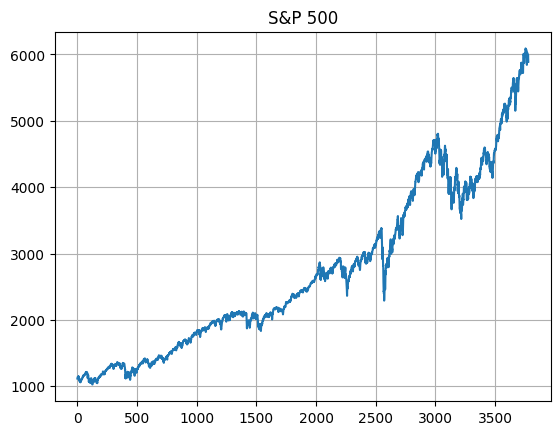

In [32]:
sp500 = yf.download("^GSPC", start="2010-01-02", end="2025-01-12", interval="1d")
sp500.columns = sp500.columns.get_level_values(0)
index_open_list=sp500["Open"].to_list()

plt.plot([i for i in range(len(index_open_list))],index_open_list)
plt.grid()
plt.title('S&P 500')
plt.show()

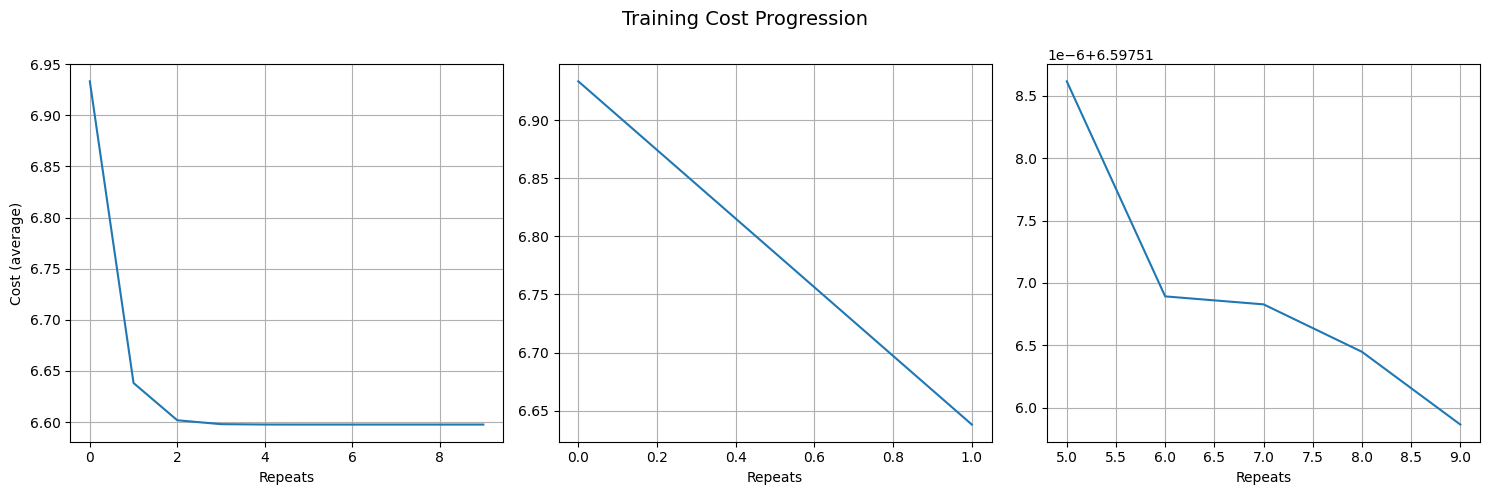

In [33]:
## Usage - Training

x=0.001
repeats=10

W1,W2,B1,B2,avg_cost=training0(training_clusters,oracle_clusters,x,repeats)

# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed
# Plot 1: Full range
axes[0].plot(range(repeats), avg_cost)
axes[0].set_xlabel('Repeats')
axes[0].set_ylabel('Cost (average)')
axes[0].grid()
# Plot 2: From repeats//4 to end
axes[1].plot(range(repeats//4), avg_cost[:repeats//4])
axes[1].set_xlabel('Repeats')
axes[1].grid()
# Plot 3: From repeats//2 to end
axes[2].plot(range(repeats//2, repeats), avg_cost[repeats//2:])
axes[2].set_xlabel('Repeats')
axes[2].grid()
# Set a single title for the entire figure
fig.suptitle('Training Cost Progression', fontsize=14)
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Average cost on testing : 6.677593660430389 --- Highest cost on testing : 17.86426770793544


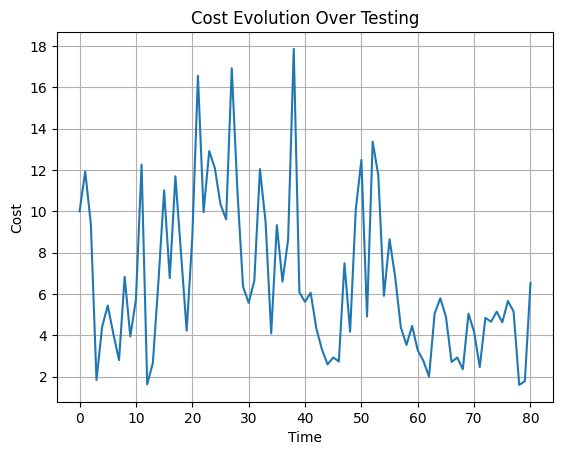

In [34]:
## Usage - Testing

mean, max, all_costs = testing(test_samples,reality_samples,W1,W2,B1,B2)

print(f'Average cost on testing : {mean} --- Highest cost on testing : {max}')

plt.plot([i for i in range(len(all_costs))],all_costs)
plt.title('Cost Evolution Over Testing')
plt.xlabel('Time')
plt.ylabel('Cost')
plt.grid()
plt.show()

#print(prediction(test_samples[0],W1,W2,B1,B2))
#print(test_samples[0])
#print(reality_samples[0])

Analysis

Average error - Corr from NN : 0.17765408628397547
Average error - Corr from Sample : 0.35079644857594305
Average error difference (Sample - NN) : 0.17314236229196764


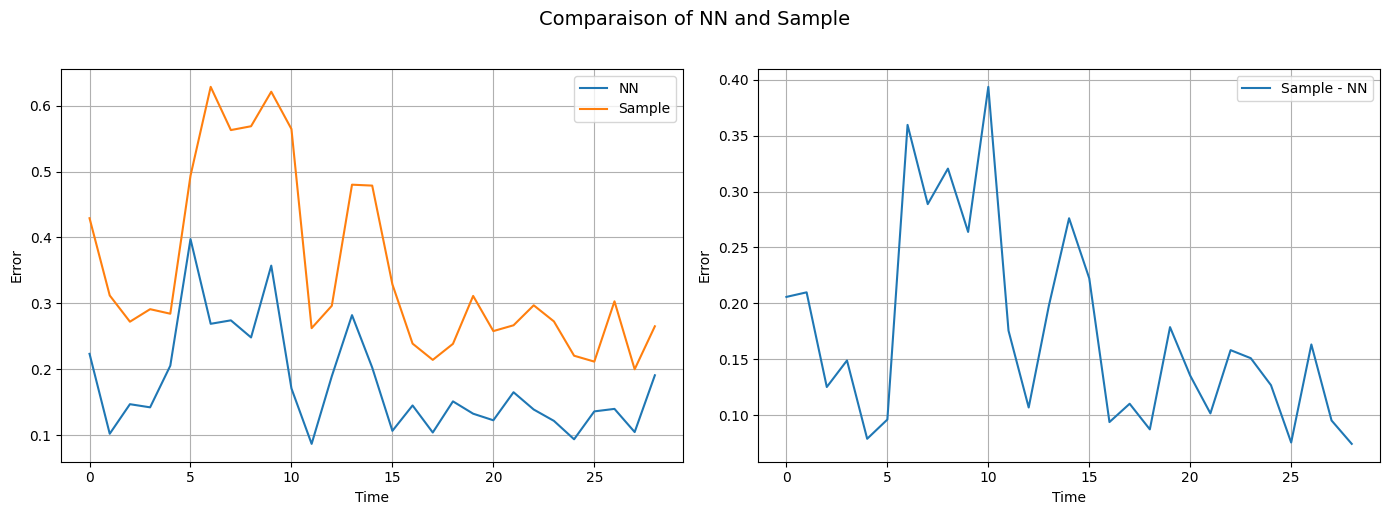

In [35]:
## Analysis - Comparaison

def reconstruct(eig_values,vectors):            # both lists have to be consistently sorted
    n=np.shape(eig_values)[0]
    M=np.array([vectors[i] for i in range(n)]).T
    return M @ np.diag(eig_values) @ np.linalg.inv(M)

def Frobenius_norm(M,N):
    n=np.shape(M)[0]
    return np.sum((M-N)**2) / n**2

def comparaison(W1,W2,B1,B2,out_of_sample,window):
    error_NN=[]
    error_Sample=[]
    compar=[]

    for i in range(np.shape(out_of_sample)[0]//window - 1):

        past_eigenvalues,past_eigenvectors=np.linalg.eig(np.corrcoef(out_of_sample[i*window:(i+1)*window].T))
        sorted_indices=np.argsort(past_eigenvalues)
        predicted_eig_values=prediction(past_eigenvalues[sorted_indices],W1,W2,B1,B2)
        NN_corr = reconstruct(predicted_eig_values[sorted_indices],past_eigenvectors[sorted_indices])
        sample_corr,sample_vect = np.linalg.eig(np.corrcoef(out_of_sample[i*window:(i+1)*window].T))
        Sample_corr = reconstruct(sample_corr[sorted_indices],sample_vect[sorted_indices])

        real_eig,real_vect = np.linalg.eig(np.corrcoef(out_of_sample[(i+1)*window:(i+2)*window].T))
        Real_corr = reconstruct(real_eig[sorted_indices],real_vect[sorted_indices])

        error_NN.append(Frobenius_norm(NN_corr,Real_corr))
        error_Sample.append(Frobenius_norm(Sample_corr,Real_corr))

    compar = np.array(error_Sample) - np.array(error_NN)
    return error_NN, error_Sample, compar

error_NN, error_Sample, compar = comparaison(W1,W2,B1,B2,past[8*np.shape(past)[0]//10:,:n],window)
print(f'Average error - Corr from NN : {np.mean(error_NN)}')
print(f'Average error - Corr from Sample : {np.mean(error_Sample)}')
print(f'Average error difference (Sample - NN) : {np.mean(compar)}')

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# Plot 1: Average Cost
ax1.plot([i for i in range(len(error_NN))], error_NN, label=f'NN')
ax1.plot([i for i in range(len(error_Sample))], error_Sample, label=f'Sample')
ax1.set_xlabel('Time')
ax1.set_ylabel('Error')
ax1.legend()
ax1.grid()
# Plot 2: Highest Cost
ax2.plot([i for i in range(np.shape(compar)[0])], compar, label=f'Sample - NN')
ax2.set_xlabel('Time')
ax2.set_ylabel('Error')
ax2.legend()
ax2.grid()
# Set a single title for the entire figure
fig.suptitle('Comparaison of NN and Sample', fontsize=14, y=1.02)
# Adjust layout to prevent overlap
plt.tight_layout()

In [36]:
## Analysis - Training length

L_avg_loss_testing_Rep, L_max_loss_testing_Rep=[],[]
X=[0.001,0.002]

R=10

for x in X:

    avg_loss_testing_Rep, max_loss_testing_Rep=[],[]

    for i in range(R):
        W1,W2,B1,B2,avg_cost = training0(training_clusters,oracle_clusters,x,2*(i+1))
        a,b,c = testing(test_samples,reality_samples,W1,W2,B1,B2)
        avg_loss_testing_Rep.append(a)
        max_loss_testing_Rep.append(b)
    
    L_avg_loss_testing_Rep.append(avg_loss_testing_Rep)
    L_max_loss_testing_Rep.append(max_loss_testing_Rep)

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# Plot 1: Average Cost
for i in range(len(X)):
    ax1.plot([R*(j+1) for j in range(R)], L_avg_loss_testing_Rep[i], label=f'TS={X[i]}')
ax1.set_xlabel('Repeats')
ax1.set_ylabel('Average Loss')
ax1.legend()
ax1.grid()
# Plot 2: Highest Cost
for i in range(len(X)):
    ax2.plot([R*(j+1) for j in range(R)], L_max_loss_testing_Rep[i], label=f'TS={X[i]}')
ax2.set_xlabel('Repeats')
ax2.set_ylabel('Highest Loss')
ax2.legend()
ax2.grid()
# Set a single title for the entire figure
fig.suptitle('Repeat Influence on Loss for Diverse Training Speeds', fontsize=14, y=1.02)
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

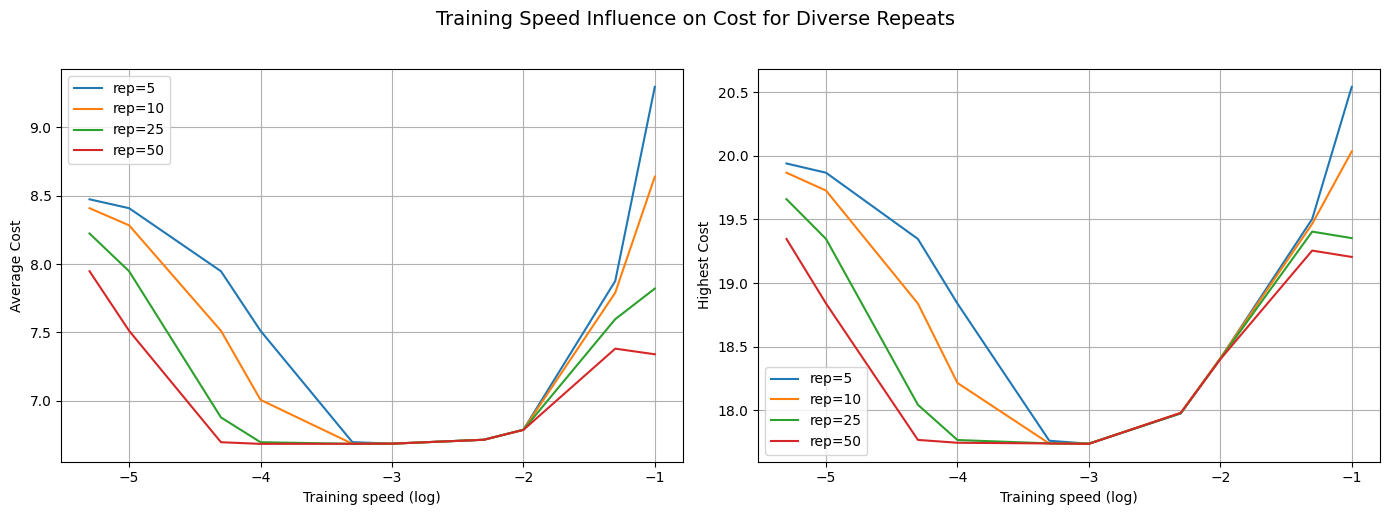

In [ ]:
## Analysis - Training speed

L_avg_loss_testing_TS, L_max_loss_testing_TS=[],[]
Rep=[5,10,25,50]

X=[0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]

for repeats in Rep:

    avg_loss_testing_TS, max_loss_testing_TS=[],[]

    for i in range(len(X)):
        
        x=X[i]
        W1,W2,B1,B2,avg_cost = training0(training_clusters,oracle_clusters,x,repeats)
        a,b,c = testing(test_samples,reality_samples,W1,W2,B1,B2)
        avg_loss_testing_TS.append(a)
        max_loss_testing_TS.append(b)
    
    L_avg_loss_testing_TS.append(avg_loss_testing_TS)
    L_max_loss_testing_TS.append(max_loss_testing_TS)

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# Plot 1: Average Cost
for i in range(len(Rep)):
    ax1.plot(np.log10(X), L_avg_loss_testing_TS[i], label=f'rep={Rep[i]}')
ax1.set_xlabel('Training rate (log)')
ax1.set_ylabel('Average Loss')
ax1.legend()
ax1.grid()
# Plot 2: Highest Cost
for i in range(len(Rep)):
    ax2.plot(np.log10(X), L_max_loss_testing_TS[i], label=f'rep={Rep[i]}')
ax2.set_xlabel('Training rate (log)')
ax2.set_ylabel('Highest Loss')
ax2.legend()
ax2.grid()
# Set a single title for the entire figure
fig.suptitle('Training Speed Influence on Loss for Diverse Repeats', fontsize=14, y=1.02)
# Adjust layout to prevent overlap
plt.tight_layout()

Backtest

Matrix calculations start
Training 1
Training 2
Training 3
Training 4
Training 5
Matrix done --> Backtest start
[[0.04658629]
 [0.05227039]
 [0.046929  ]
 [0.05520938]
 [0.05358035]
 [0.04892694]
 [0.05322764]
 [0.04942554]
 [0.05045111]
 [0.05115675]
 [0.04541197]
 [0.047487  ]
 [0.05247797]
 [0.0468131 ]
 [0.05164062]
 [0.04838233]
 [0.04847193]
 [0.04985771]
 [0.05081852]
 [0.05087546]]
Backtest done
Greatest draw down - SI : 0.33422609435551087
Greatest draw down - Sample : 0.2168105250861837
Greatest draw down - NN : 0.3561636123404177
Greatest draw down - S&P500 : 0.33924960002653315


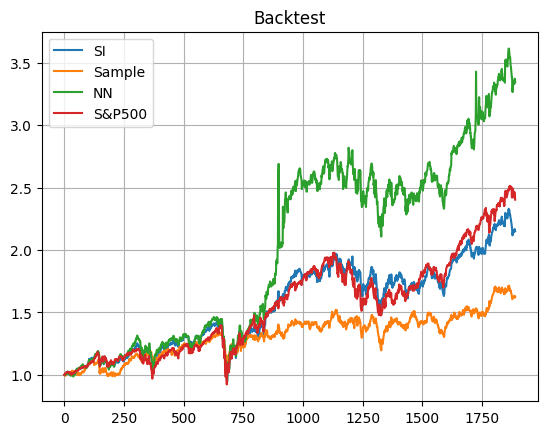

In [ ]:
import pandas as pd
import numpy as np
import numpy.linalg as alg
import matplotlib.pyplot as plt
from functools import reduce


df = pd.read_csv("sp500_prices.csv")
df_prices = df.iloc[:, 1:].astype(float)
stock_opens = df_prices.to_numpy()
stock_opens = stock_opens[:, ~np.isnan(stock_opens).any(axis=0)]
sp500 = pd.read_csv("sp500_indice.csv")
sp500 = sp500.iloc[:, 1:].astype(float)
sp500_open_list = sp500.to_numpy()

time=np.shape(stock_opens)[0]

stock_variations = stock_opens[1:] / stock_opens[:-1]

# oldest times at the top and most recent ones at the bottom
rand_pick=np.random.choice(331, size=20, replace=False)
past, future = stock_variations[:(time-1)//2,rand_pick], stock_variations[(time-1)//2:,rand_pick]
past_sp500 = sp500_open_list[:(time-1)//2]
future_sp500 = sp500_open_list[(time-1)//2:]

nbr=np.shape(past)[1]


# Works only if T>N
def sample_method(Past):
    return np.cov(Past,rowvar=False,bias=False)

def SI_method(Past,index_open_list,m):
    T=np.shape(index_open_list)[0]-1
    # f calculation
    f= np.array(index_open_list)[1:] / np.array(index_open_list[:-1]) - 1
    f=np.array(f.flatten().tolist())
    E_f=np.mean(f)
    V_f=np.var(f)
    # constants calculations
    Beta=np.zeros((nbr,1))
    for j in range(nbr):
        variation_stock =  np.array([Past[i][j] for i in range(T)])
        Beta[j,0] = np.cov(variation_stock,f,ddof=0)[0,1]
    Alpha = m - E_f*Beta
    Eps = [[Past[i][j]-Beta[j][0]*f[i]-Alpha[j][0] for i in range(T)] for j in range(nbr)]
    D=np.diag([np.var(Eps[i]) for i in range(nbr)])
    return V_f * Beta @ Beta.T + D


# returns the weight vector that minimizes the portfolio's variance and provides a r return
def opti(r,Sigma,SigmaInv,m):

    N=np.shape(m)[0]
    I=np.ones((N,1))

    A=np.dot(np.dot(np.transpose(I),SigmaInv),I)
    B=np.dot(np.dot(np.transpose(I),SigmaInv),m)
    C=np.dot(np.dot(np.transpose(m),SigmaInv),m)
    Delta=np.dot(A,C)-np.dot(B,B)

    l=(C-r*B)/Delta
    g=(r*A-B)/Delta

    return l*np.dot(SigmaInv,I)+g*np.dot(SigmaInv,m)

def marko(r,Sigma,m):
    n = Sigma.shape[0]
    w = cp.Variable(n)
    constraints = [cp.sum(w) == 1, w >= 0]

# Objectif : minimiser la variance
    objective = cp.Minimize(cp.quad_form(w, Sigma))

# Problème
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return w.value

def greatest_draw_down(value_asset):
    greatest_dd=1
    current_high=value_asset[0]
    for i in range(1,len(value_asset)):
        if value_asset[i] >= current_high:
            current_high=value_asset[i]
        if value_asset[i]/current_high < greatest_dd:
            greatest_dd=value_asset[i]/current_high
    return 1-greatest_dd
def greatest_daily_loss(value_asset):
    return 1-np.min(value_asset)
def period_vol(value_asset,dT):
    w_vol=[]
    period=[]
    for i in range(len(value_asset)):
        if i%dT==0 and i!=0:
            w_vol.append(np.var(period))
            period=[]
        else: period.append(value_asset[i])
    return w_vol


# h pas de discretisation, s starting return
h=0.002
s=1.00001
R=[s+0.004*h*i for i in range(int(1/h))]


# Time series

# Settings
m=np.mean(past, axis=0, keepdims=True).T
Sigma_SI=SI_method(past,sp500_open_list[:np.shape(past)[0]+1],m)
Sigma_Sample=sample_method(past)
SigmaInv_SI=alg.inv(Sigma_SI)
SigmaInv_Sample=alg.inv(Sigma_Sample)
r_SI=R[np.argmin([float(marko(r,Sigma_SI,m).T @ Sigma_SI @ marko(r,Sigma_SI,m)) for r in R])]
r_Sample=R[np.argmin([float(marko(r,Sigma_Sample,m).T @ Sigma_Sample @ marko(r,Sigma_Sample,m)) for r in R])]

dT=10
upd_Sigma_SI,upd_Sigma_inv_SI,upd_Sigma_NN = [],[],[]
upd_Sigma_Sample,upd_Sigma_inv_Sample,upd_Sigma_inv_NN = [Sigma_Sample],[SigmaInv_Sample],[]
upd_m=[]
upd_Past=past

window=50
step=5

# Time loops

print('Matrix calculations start')

for i in range(np.shape(future)[0]):
    if i%(np.shape(past)[0]//4)==0:
        print(f'Training {1 + i//(np.shape(past)[0]//4)}')
        training_clusters, oracle_clusters = make_data_full(upd_Past,window,step)
        W1,W2,B1,B2,avg_cost=training0(training_clusters,oracle_clusters,x,100)
    
    if i%dT==0 :      # Maybe we can avoid this by writing the range differently but idk how

        past_eigenvalues,past_eigenvectors=np.linalg.eig(np.corrcoef(upd_Past[-20:].T))
        sorted_indices=np.argsort(past_eigenvalues)
        reverse_sort=np.argsort(sorted_indices)
        predicted_eig_values=prediction(past_eigenvalues[sorted_indices],W1,W2,B1,B2)
        to_var=np.std(upd_Past[-20:],axis=0)
        uSig_NN = reconstruct(predicted_eig_values[sorted_indices][reverse_sort],past_eigenvectors[sorted_indices][reverse_sort]) * (to_var.T @ to_var)
        upd_Sigma_NN.append(uSig_NN)
        upd_Sigma_inv_NN.append(alg.inv(uSig_NN))

        upd_m.append(np.mean(upd_Past, axis=0, keepdims=True).T)

        uSig_SI=SI_method(upd_Past,sp500_open_list[i:np.shape(past)[0]+i+1],upd_m[-1])
        uSig_Sample=sample_method(upd_Past)
        upd_Sigma_SI.append(uSig_SI)
        upd_Sigma_Sample.append(uSig_Sample)
        upd_Sigma_inv_SI.append(alg.inv(uSig_SI))
        upd_Sigma_inv_Sample.append(alg.inv(uSig_Sample))

    upd_Past[:-1]=upd_Past[1:]
    upd_Past[-1]=future[i]

print('Matrix done --> Backtest start')

future_perf_Upd_SI,future_perf_Upd_Sample,future_perf_Upd_NN=[],[],[]
r_SI=R[np.argmin([float(marko(r,Sigma_SI,m).T @ Sigma_SI @ marko(r,Sigma_SI,m)) for r in R])]
r_Sample=R[np.argmin([float(marko(r,Sigma_Sample,m).T @ Sigma_Sample @ marko(r,Sigma_Sample,m)) for r in R])]
r_NN=R[np.argmin([float(marko(r,upd_Sigma_NN[0],m).T @ upd_Sigma_NN[0] @ marko(r,upd_Sigma_NN[0],m)) for r in R])]
w_SI=marko(r_SI,Sigma_SI,upd_m[0])
w_Sample=marko(r_Sample,Sigma_Sample,upd_m[0])
w_NN=marko(r_NN,upd_Sigma_NN[0],upd_m[0])

for i in range(np.shape(future)[0]):
    columna = future[i]
    future_perf_Upd_SI.append((w_SI.T @ columna)[0])
    future_perf_Upd_Sample.append((w_Sample.T @ columna)[0])
    future_perf_Upd_NN.append((w_NN.T @ columna)[0])
    if i%dT==0 and i!=0 :
        r_SI=R[np.argmin([float(marko(ret,upd_Sigma_SI[i//dT],upd_m[i//dT]).T @ upd_Sigma_SI[i//dT] @ marko(ret,upd_Sigma_SI[i//dT],upd_m[i//dT])) for ret in R])]
        r_Sample=R[np.argmin([float(marko(ret,upd_Sigma_Sample[i//dT],upd_m[i//dT]).T @ upd_Sigma_Sample[i//dT] @ marko(ret,upd_Sigma_Sample[i//dT],upd_m[i//dT])) for ret in R])]
        r_NN=R[np.argmin([float(marko(ret,upd_Sigma_NN[i//dT],upd_m[i//dT]).T @ upd_Sigma_NN[i//dT] @ marko(ret,upd_Sigma_NN[i//dT],upd_m[i//dT])) for ret in R])]
        w_SI=marko(r_SI,upd_Sigma_SI[i//dT],upd_m[i//dT])
        w_Sample=marko(r_Sample,upd_Sigma_Sample[i//dT],upd_m[i//dT])
        w_NN=marko(r_NN,upd_Sigma_NN[i//dT],upd_m[i//dT])
    else :
        w_SI = w_SI * future[i][:, np.newaxis] / (w_SI.T @ future[i][:, np.newaxis])[0]
        w_Sample = w_Sample * future[i][:, np.newaxis] / (w_Sample.T @ future[i][:, np.newaxis])[0]
        w_NN = w_NN * future[i][:, np.newaxis] / (w_NN.T @ future[i][:, np.newaxis])[0]
print(w_NN)
print('Backtest done')

value_portfolio_Upd_SI,value_portfolio_Upd_Sample,value_portfolio_Upd_NN=[1],[1],[1]
for i in range(np.shape(future)[0]-1):
    value_portfolio_Upd_SI.append((future_perf_Upd_SI[i]*value_portfolio_Upd_SI[-1]))
    value_portfolio_Upd_Sample.append((future_perf_Upd_Sample[i]*value_portfolio_Upd_Sample[-1]))
    value_portfolio_Upd_NN.append((future_perf_Upd_NN[i]*value_portfolio_Upd_NN[-1]))

print("Greatest draw down - SI :",greatest_draw_down(value_portfolio_Upd_SI))
print("Greatest draw down - Sample :",greatest_draw_down(value_portfolio_Upd_Sample))
print("Greatest draw down - NN :",greatest_draw_down(value_portfolio_Upd_NN))

# S&P500

index_open_list=sp500_open_list[np.shape(past)[0]+1:]
index_perf = np.array(index_open_list)[1:] / np.array(index_open_list[:-1])

value_Index = [1]
for i in range(np.shape(future)[0]-1):
    value_Index.append((index_perf[i]*value_Index[-1])[0])

print("Greatest draw down - S&P500 :",greatest_draw_down(value_Index))

# Plots

Time=[i for i in range(np.shape(future)[0])]
#plt.plot(Time,value_portfolio_BH,label='BT Buy and Hold - SI')
plt.plot(Time,value_portfolio_Upd_SI,label='SI')
plt.plot(Time,value_portfolio_Upd_Sample,label='Sample')
plt.plot(Time,value_portfolio_Upd_NN,label='NN')
plt.plot(Time,value_Index,label='S&P500')
plt.title('Backtest')
plt.legend()
plt.grid()
plt.show()


In [1]:
pip install cvxpy

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------- ----------- 0.8/1.1 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 4.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/892.6 kB ? eta -:--:--
   ---------------------------------------- 892.6/892.6 kB 5.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.4 MB 4.2 MB/s eta 0:00:02
   -- ------------------------------------- 0.5/7.4 MB 4.2 MB/s eta 0:00:02
   ----- ---------------------------------- 1.0/7.4 MB 1.4 MB/s eta 0:00:05
   --------- ------------------------------ 1.8/7.4 MB 2.0 MB/s eta 0:00:03
   --------------- ------------------------ 2.9/7.4 MB 2.7 MB/s eta 0:00:02
   ---------------- ----------------------- 3.1/7.4 MB 2.8 MB/s eta 0:00:02
   ---------------- ----------------------- 3.1/7.4 MB 2.8 MB/s eta 0:00:02
   ------------------ -----


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
